<a href="https://colab.research.google.com/github/collisionattack/istanbul-traffic-forecasting/blob/main/notebooks/notebook_v1_0_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Reading the Data

In [ ]:
import requests
import pandas as pd

def fetch_traffic_batches(resource_id: str, batch_size: int = 1000):
    """
    Generator that yields pandas.DataFrame chunks of traffic data.

    :param resource_id: CKAN resource UUID for the Istanbul traffic index.
    :param batch_size:  Number of rows to fetch per HTTP request.
    """
    BASE_URL = "https://data.ibb.gov.tr/api/3/action/datastore_search"
    offset   = 0

    while True:
        params = {
            "resource_id": resource_id,
            "limit":      batch_size,
            "offset":     offset
        }
        resp = requests.get(BASE_URL, params=params)
        resp.raise_for_status()
        records = resp.json()["result"]["records"]

        if not records:
            break

        df_chunk = pd.DataFrame(records)
        df_chunk["trafficindexdate"] = pd.to_datetime(df_chunk["trafficindexdate"])

        yield df_chunk

        offset += batch_size

In [ ]:
RESOURCE_ID = "ba47eacb-a4e1-441c-ae51-0e622d4a18e2"

for i, batch_df in enumerate(fetch_traffic_batches(RESOURCE_ID, batch_size=500)):
    print(f"Processing batch {i+1} with {len(batch_df)} rows")
    # — e.g., do preprocessing, feature extraction, model training on this batch
    # batch_df.to_parquet(f"data/batch_{i+1}.parquet")  # or append to a database


Processing batch 1 with 500 rows
Processing batch 2 with 500 rows
Processing batch 3 with 500 rows
Processing batch 4 with 500 rows
Processing batch 5 with 500 rows
Processing batch 6 with 500 rows
Processing batch 7 with 332 rows


## 2. EDA Section

In [ ]:
# Getting the first batch
batch_gen = fetch_traffic_batches(RESOURCE_ID, batch_size=500)
first_batch = next(batch_gen)

In [ ]:
first_batch.head()

,_id,trafficindexdate,minimum_traffic_index,maximum_traffic_index,average_traffic_index
0,1,2015-08-06 03:00:00,24,63,57.858116
1,2,2015-08-07 03:00:00,2,49,23.770492
2,3,2015-08-11 03:00:00,11,62,38.601266
3,4,2015-08-12 03:00:00,1,63,29.715278
4,5,2015-08-13 03:00:00,2,56,28.557491


In [ ]:
first_batch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   _id                    500 non-null    int64         
 1   trafficindexdate       500 non-null    datetime64[ns]
 2   minimum_traffic_index  500 non-null    int64         
 3   maximum_traffic_index  500 non-null    int64         
 4   average_traffic_index  500 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 19.7 KB


In [ ]:
first_batch.describe()

,_id,trafficindexdate,minimum_traffic_index,maximum_traffic_index,average_traffic_index
count,500.000000,500,500.000000,500.000000,500.000000
mean,250.500000,2016-04-23 22:01:40.800000,2.452000,65.182000,30.307443
min,1.000000,2015-08-06 03:00:00,1.000000,13.000000,4.680556
25%,125.750000,2015-12-11 20:00:00,1.000000,60.000000,26.257716
50%,250.500000,2016-05-01 15:00:00,1.000000,69.000000,31.389295
75%,375.250000,2016-09-03 09:00:00,2.000000,74.000000,36.294216
max,500.000000,2017-01-06 03:00:00,58.000000,90.000000,59.428571
std,144.481833,NaN,4.172591,14.620273,8.463089


In [ ]:
# Checking the total of NaN values
first_batch.isna().sum()

,0
_id,0
trafficindexdate,0
minimum_traffic_index,0
maximum_traffic_index,0
average_traffic_index,0


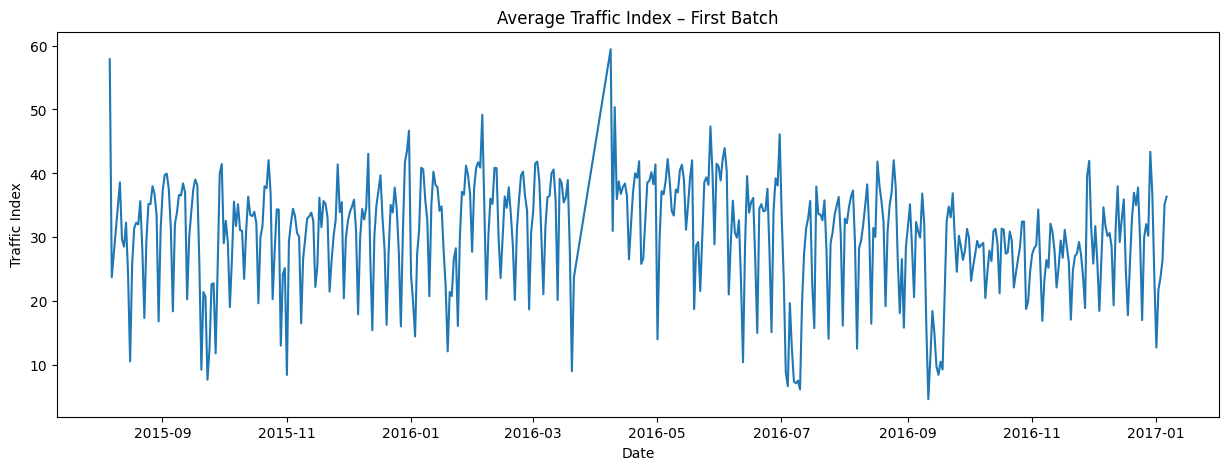

In [ ]:
# First visual inspection
import matplotlib.pyplot as plt

first_batch_sorted = first_batch.sort_values("trafficindexdate")
plt.figure(figsize=(15, 5))
plt.plot(first_batch_sorted["trafficindexdate"], first_batch_sorted["average_traffic_index"])
plt.title("Average Traffic Index – First Batch")
plt.xlabel("Date")
plt.ylabel("Traffic Index")
plt.show()

### 2a. Batch Inspection

In [ ]:
# Filling the gaps for consistency
first_batch = first_batch.set_index("trafficindexdate").asfreq("D")

In [ ]:
# Imputing missing values for some of the time gaps
first_batch["minimum_traffic_index"] = first_batch["minimum_traffic_index"].ffill().bfill()
first_batch["maximum_traffic_index"] = first_batch["maximum_traffic_index"].ffill().bfill()
first_batch["average_traffic_index"] = first_batch["average_traffic_index"].interpolate()

In [ ]:
# Feature engineering part-1
first_batch["day_of_week"] = first_batch.index.dayofweek
first_batch["month"] = first_batch.index.month
first_batch["is_weekend"] = (first_batch["day_of_week"] >= 5).astype(int)

In [ ]:
# Feature engineering part-2 -> Lags for temporal learning
for lag in [1, 2, 7]:
    first_batch[f"lag_{lag}"] = first_batch["average_traffic_index"].shift(lag)

In [ ]:
# Feature engineering part-3 -> Rolling average (trend)
first_batch["rolling_mean_7"] = first_batch["average_traffic_index"].rolling(7).mean()

In [ ]:
# Feature engineering part-4 -> Drop rows with NaNs from lags/rolling
first_batch = first_batch.dropna()

## 2b. Data Split

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

In [ ]:
df = first_batch.copy()

In [ ]:
# Defining features and target
TARGET   = "average_traffic_index"
FEATURES = [c for c in df.columns if c != TARGET]

In [ ]:
# Reserve final 15% as hold-out test
n = len(df)
test_start = int(n * 0.85)
df_trainval = df.iloc[:test_start]
df_test = df.iloc[test_start:]

In [ ]:
print(f"Total of train and val: {len(df_trainval)} rows,  Test : {len(df_test)} rows")

Total of train and val: 307 rows,  Test : 55 rows


In [ ]:
# Rolling‐window CV on train and val
tscv = TimeSeriesSplit(n_splits=5)
for fold, (train_idx, val_idx) in enumerate(tscv.split(df_trainval), 1):
    X_tr = df_trainval.iloc[train_idx][FEATURES]
    y_tr = df_trainval.iloc[train_idx][TARGET]
    X_vl = df_trainval.iloc[val_idx][FEATURES]
    y_vl = df_trainval.iloc[val_idx][TARGET]

    # Scaling on train only
    scaler = StandardScaler().fit(X_tr)
    X_tr_scl = scaler.transform(X_tr)
    X_vl_scl = scaler.transform(X_vl)

    # Fitting a quick baseline model for now
    model = LinearRegression().fit(X_tr_scl, y_tr)
    preds = model.predict(X_vl_scl)
    print(f"Fold {fold} — MAE: {mean_absolute_error(y_vl, preds):.3f}")

Fold 1 — MAE: 3.853
Fold 2 — MAE: 2.807
Fold 3 — MAE: 2.247
Fold 4 — MAE: 2.334
Fold 5 — MAE: 2.389


In [ ]:
scaler_final = StandardScaler().fit(df_trainval[FEATURES])
X_tv = scaler_final.transform(df_trainval[FEATURES])
y_tv = df_trainval[TARGET]
final_model = LinearRegression().fit(X_tv, y_tv)

In [ ]:
# Evaluating on the 15%
X_te = scaler_final.transform(df_test[FEATURES])
y_te = df_test[TARGET]
test_mae = mean_absolute_error(y_te, final_model.predict(X_te))
print(f"Final Test MAE: {test_mae:.3f}")

Final Test MAE: 2.296
